In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import networkx as nx
from scipy.spatial.distance import cdist
from combine_gtfs_feeds import cli
import os

In [ ]:
# Basic geographic setup

In [25]:
from citychef import spatial
from citychef import graph
from citychef import household as hh
from citychef import tree
from citychef import osm
from citychef import gtfs

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
city_dir = "./sample_setup"

if not os.path.exists(city_dir):
    os.mkdir(city_dir)
else:
    print("WARNING - potentially overwritting previous results")

WARNING - potentially overwritting previous results


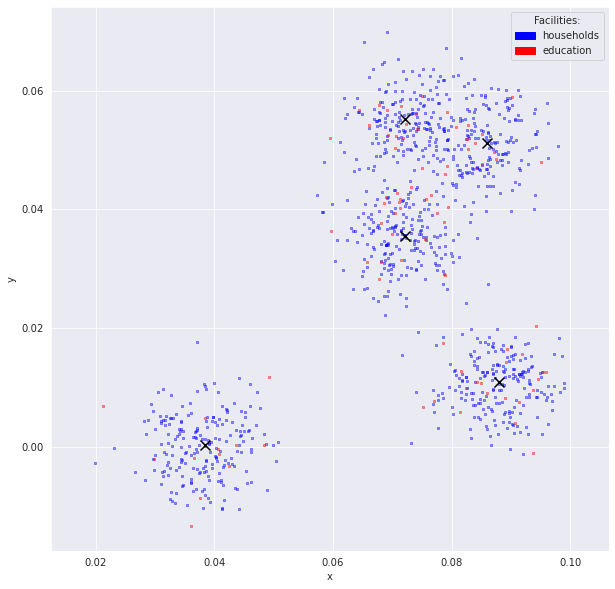

In [ ]:
bbox = np.array([[0,0],[0.1,0.1]])  # min x, min y, max x, max y (DEGREES)
centres = spatial.Centres(bbox, number=5)
facilities = {
    'households': spatial.Clusters(centres, size=1000, sigma=.005),
    'education': spatial.Clusters(centres, size=100, sigma=.005),
}
bbox = spatial.collect_bbox(facilities) # adjust the bbox for max extends
spatial.plot_facilities(facilities, centres)

(0.014470816673691786,
 0.10563133344742225,
 -0.018984309632515448,
 0.07546901714770975)

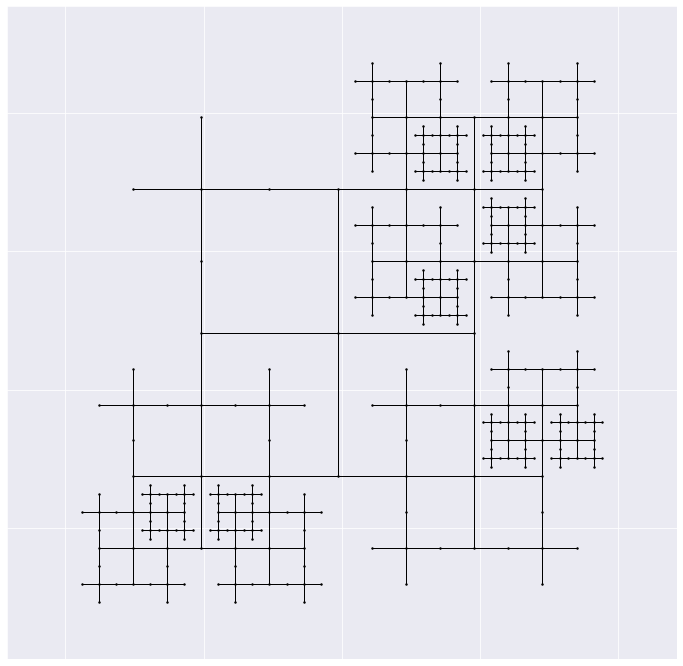

In [45]:
car_network = graph.TreeNetwork(
    bbox, facilities['households'], grid='regular', max_points=50
)
car_network.plot()
plt.axis('equal')

In [52]:
buses = graph.Transit(car_network, facilities['education'], density_radius=.01)
buses.build_routes(num_routes=10, max_length=30, min_length=11, straightness=5)

(0.014470816673691786,
 0.10563133344742225,
 -0.018984309632515448,
 0.07546901714770975)

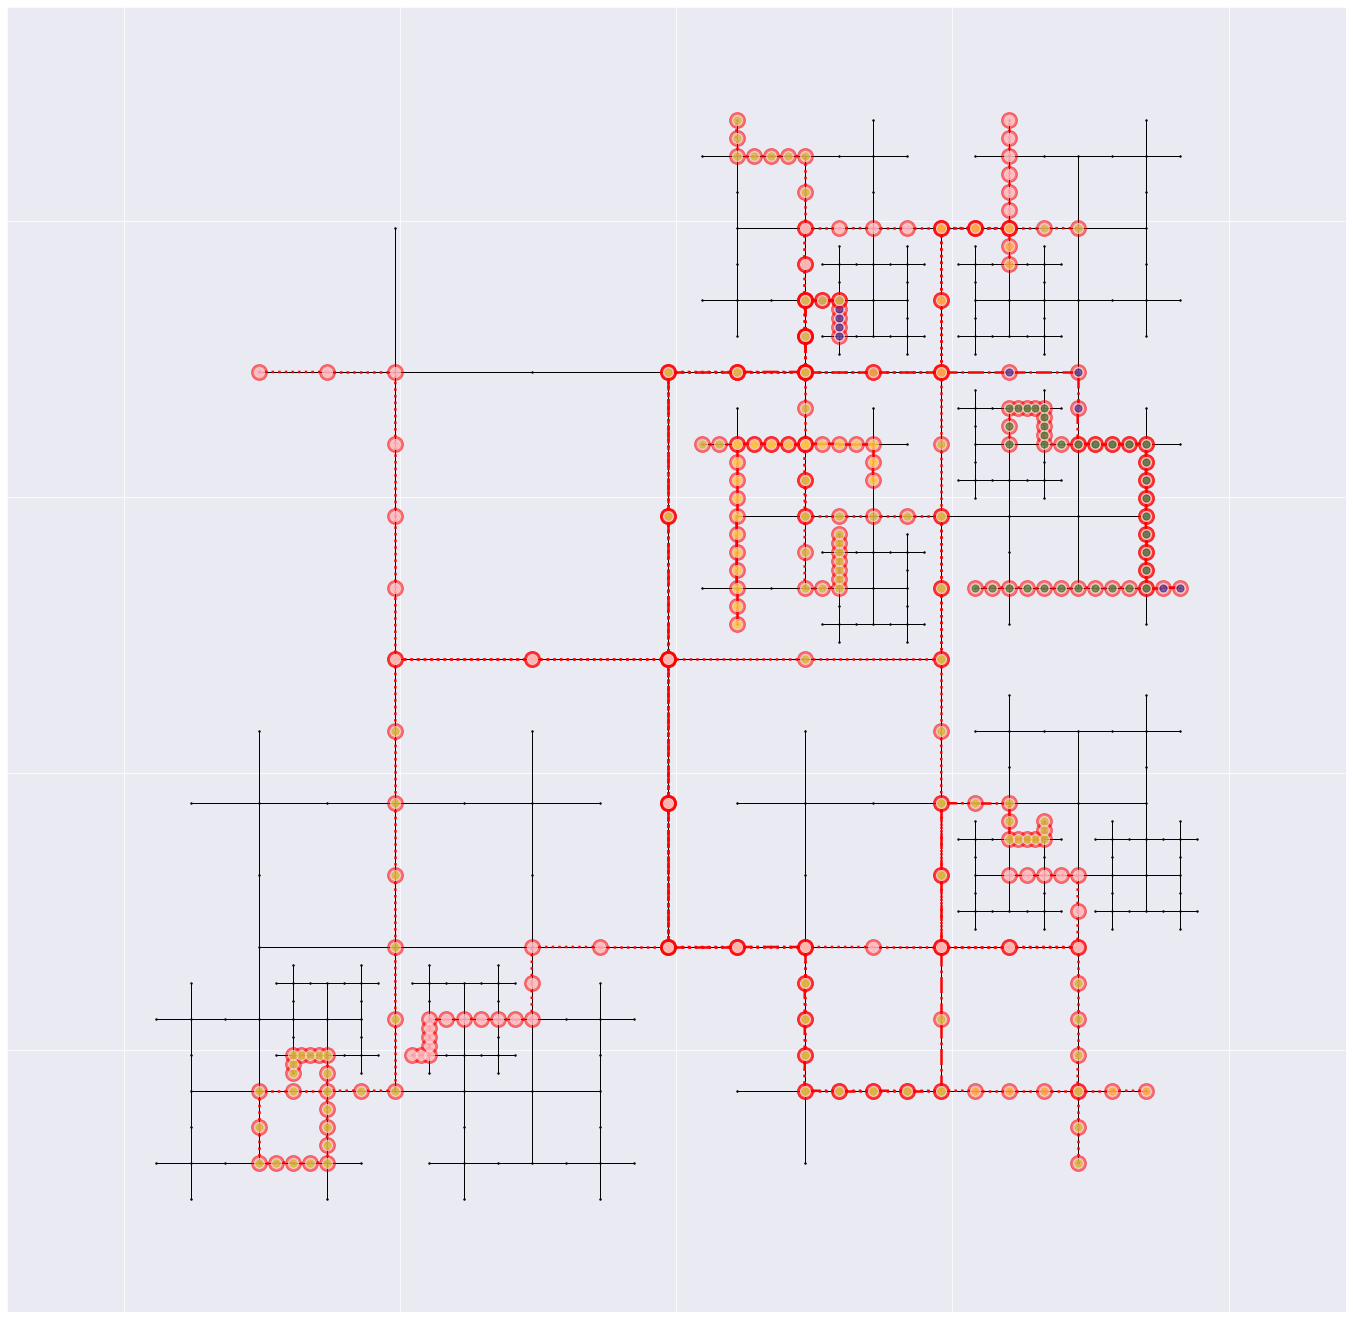

In [53]:
buses.interpolate_routes()
buses.jitter_locations(1e-08)
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
car_network.plot(ax=ax)
buses.plot(ax=ax)
plt.axis('equal')

In [54]:
# check min and max distances
print(buses.min_link_length * 111139)
print(buses.max_link_length * 111139) # approx conv to m

68.63222242050954
1705.8013920392777


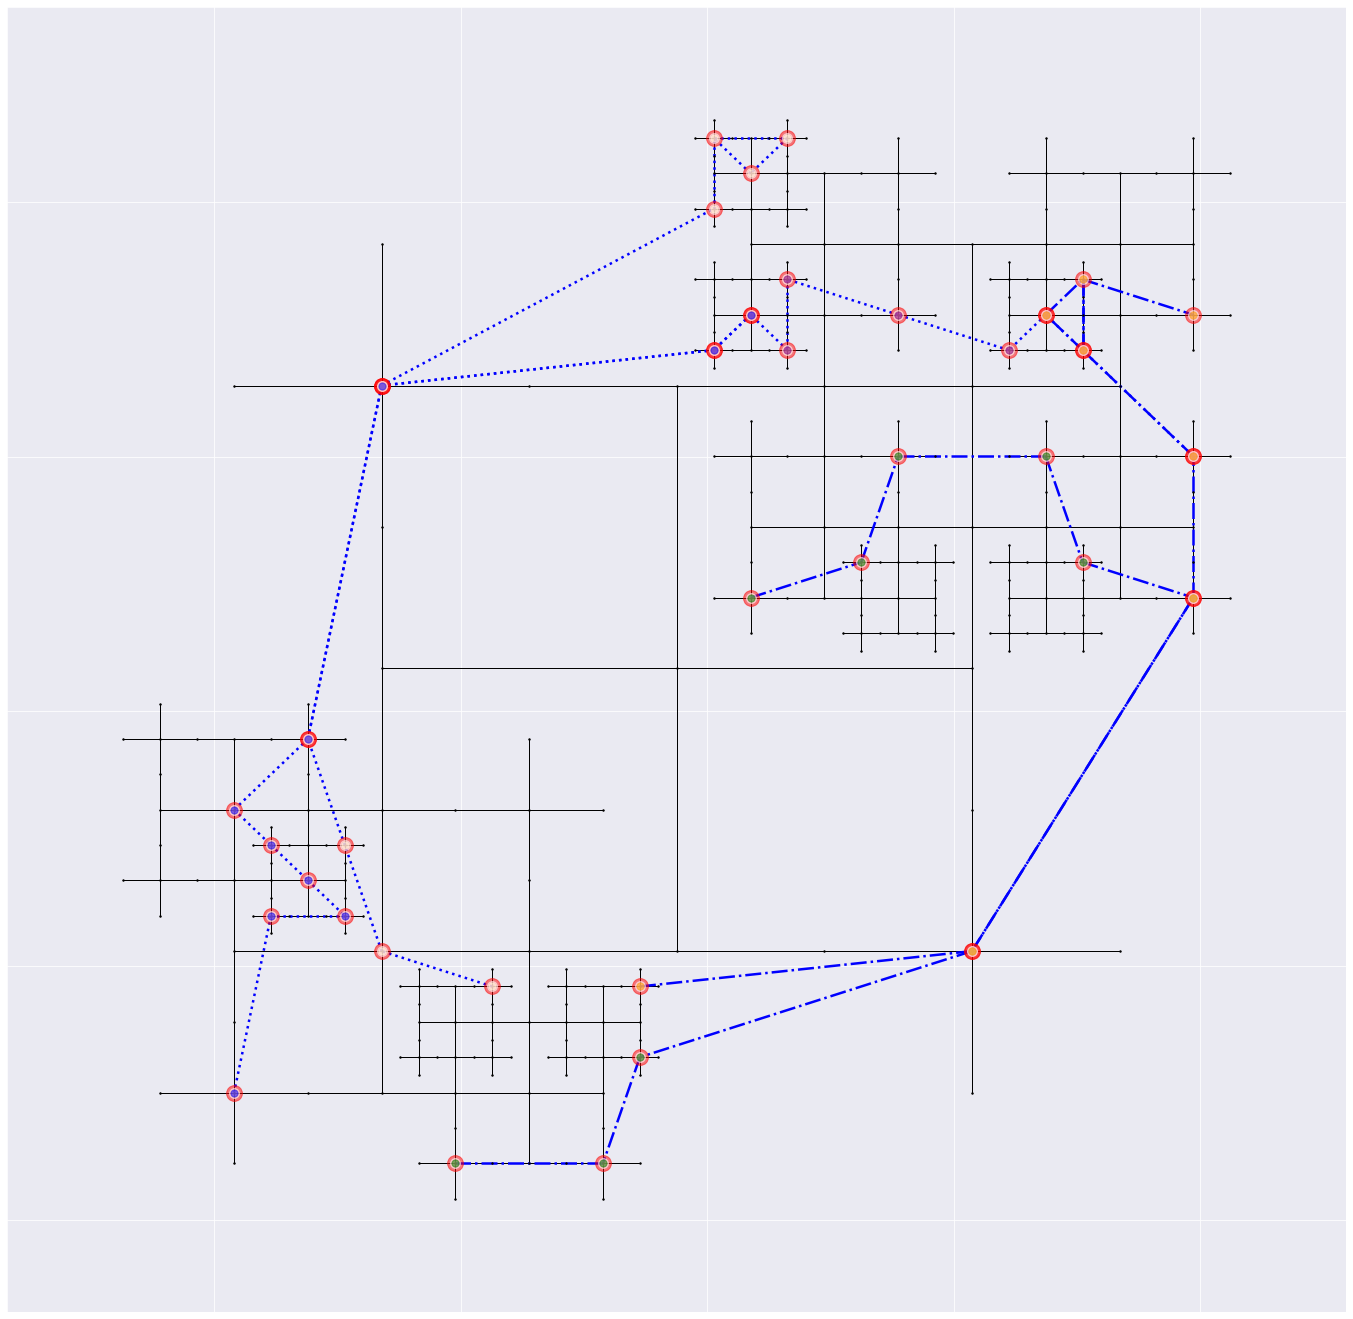

In [14]:
# first we extract potential locations for stations, we force stations to match vertices
# from the road ntwork, eg :
potential_stations = np.array([v['pos'] for k, v in car_network.g.nodes.items() if k[:2] == '00'])
rail_network = graph.DelaunayNetwork(potential_stations)

trains = graph.Transit(rail_network, facilities['households'], density_radius=0.01)
train_routes = trains.build_routes(num_routes=5, max_length=10, min_length=5, straightness=30)

fig, ax = plt.subplots(1, 1, figsize=(24, 24))
car_network.plot(ax=ax)
trains.plot(ax=ax, line_colour='blue')

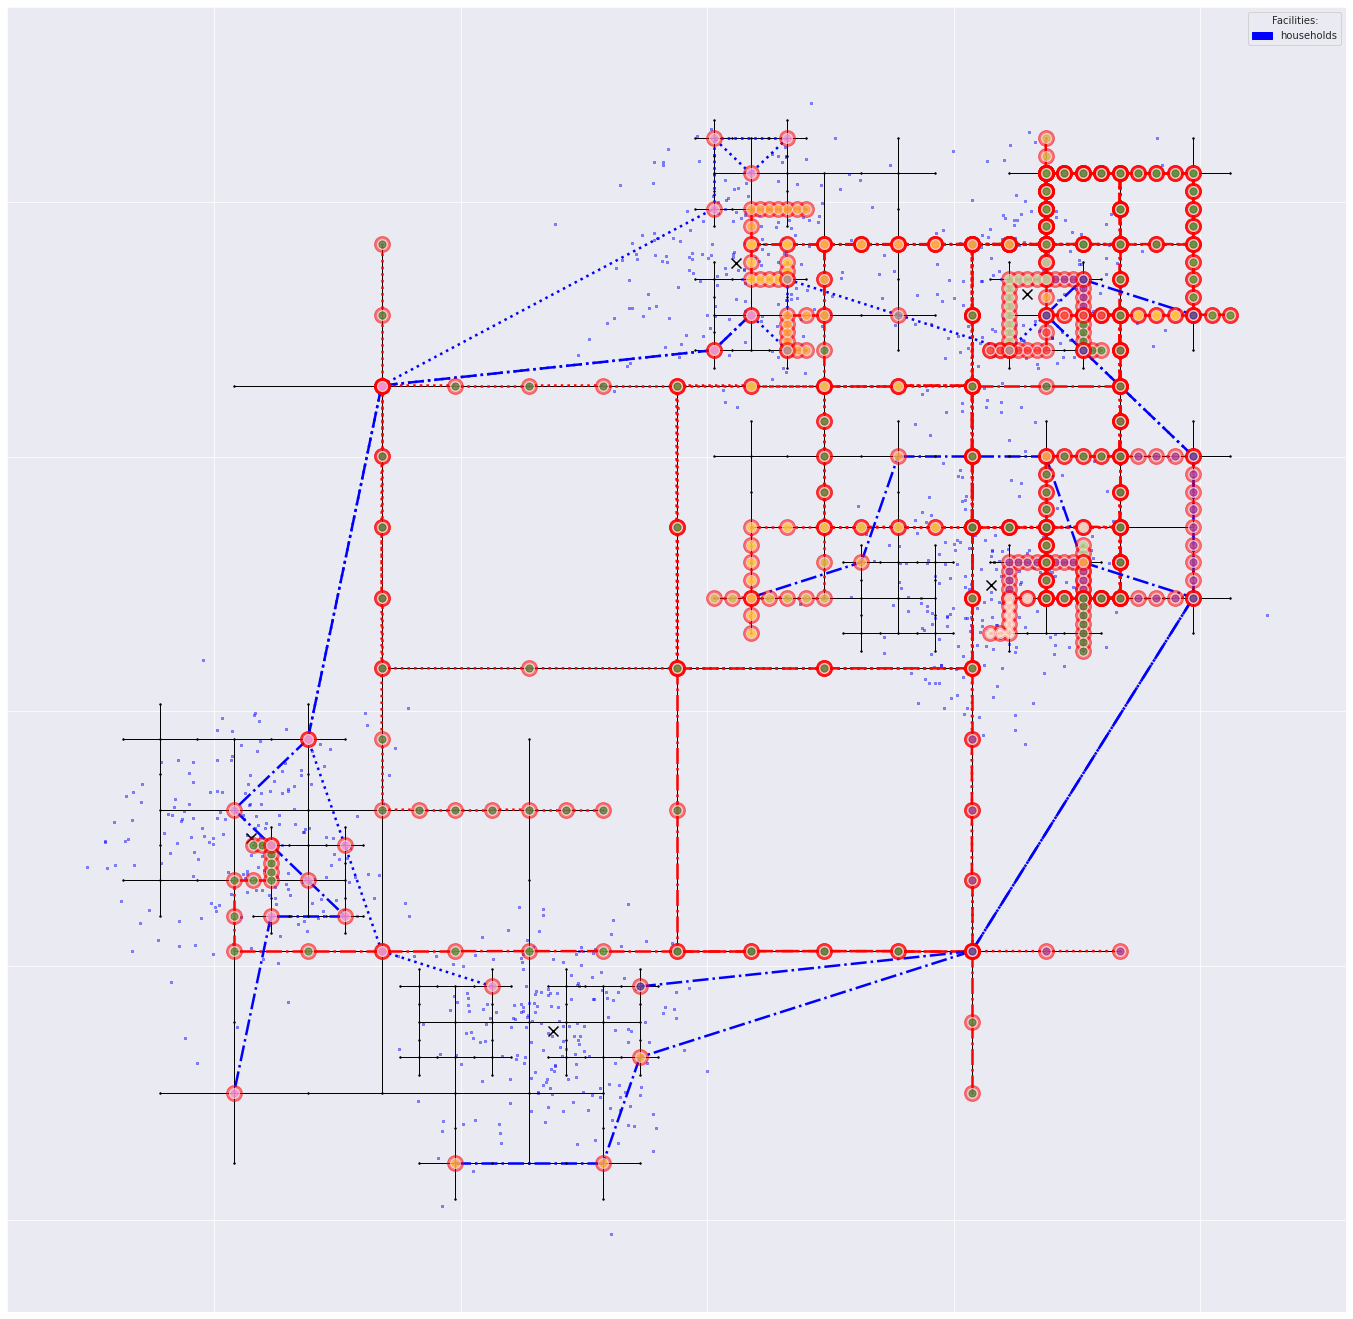

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
spatial.plot_facilities(facilities, centres=centres, ax=ax)
car_network.plot(ax=ax)
buses.plot(ax=ax)
trains.plot(ax=ax, line_colour='blue')
fig.patch.set_visible(False)
# ax.axis('off')
# plt.axis('equal')

# Creating Files

In [55]:
osm.nx_to_osm(
    g=car_network.g,
    path=os.path.join(city_dir, "osm.xml")
)

Output()

In [ ]:
"""
Converts a file from one format to another.
This example shows how to write objects to a file.
From: https://github.com/osmcode/pyosmium/blob/master/examples/convert.py
"""

import osmium as o

import sys

class Convert(o.SimpleHandler):

    def __init__(self, writer):
        super(Convert, self).__init__()
        self.writer = writer

    def node(self, n):
        self.writer.add_node(n)

    def way(self, w):
        self.writer.add_way(w)

    def relation(self, r):
        self.writer.add_relation(r)

In [ ]:
in_file = os.path.join(city_dir, "osm.xml")
out_file = os.path.join(city_dir, "osm.pbf")

if not os.path.exists(in_file):
    raise RuntimeError('need to run GTFS generation first')
if os.path.exists(out_file):
    print(f"Deleting old {in_file}")
    os.remove(out_file)

writer = o.SimpleWriter(out_file)
handler = Convert(writer)

handler.apply_file(in_file)
writer.close()

Deleting old ./sample_setup/osm.xml


In [ ]:
gtfs.build_gtfs(
    name="buses",
    transit=buses,
    out_dir=city_dir,
    agency_id=0,
    agency_name='test_bus_inc',
)

Output()

In [ ]:
gtfs.build_gtfs(
    name="trains",
    transit=trains,
    out_dir=city_dir,
    agency_id=0,
    agency_name='test_train_inc',
)

Output()